## Data Description
Disclaimer:  All satellites are in the public catalog (www.space-track.org),
but the file names are not correlated with the Satellite Catalog Number.

All observations were taken from Flagstaff AZ between 2014 and 2018.
    longitude:   -111.744380  (deg)
    latitude:    35.184570  (deg)
    elevation:   2266.0    (meter)

The files are comma-separated value (CSV), and the lines are separated by
a newline character (not CR NL).  The columns are:
   1    Modified Julian Date (MJD) of the middle of the exposure
   2    RA (deg) J2000 topocentric
   3    Dec (deg) J2000 topocentric
   4    Brightness (magnitude; band is approximately Johnson V)
   5    Error in Brightness (mag)

For those unfamiliar with satellite photometry, a catalog of visualizations
(visualization.pdf) is included in this distribution.  Each page is a false
color visualization of the satellite brightness.  The abscissa is solar phase
angle (-90 to +90 degrees), and the ordinate is day of the year. (bottom
is 56901 [2014-09-10] and the top is 58391 [2018-09-30]).  Colors range
from dark blue (faint) to white (bright).  Black areas mean no data, either
from weather, eclipse, or sensor saturation.  The black ovals come from
eclipse season.  NOTE:  This visualization is intended to be an introduction
to satellite photometry.  It is unrelated to the analysis tasks associated
with the CSV files.

##### Right Ascension & Declination
Right Ascension and Declination are a system of coordinates used in astronomy to determine the location of stars, planets and other objects in the night sky. They are similar to the system of longitude and latitude used to locate places on Earth.
#### Right Ascension (RA)
Right Ascension is measured in hours (h), minutes (m) and seconds (s) and is similar to longitude on Earth. As the Earth rotates, stars appear to rise in the East and set in the West just like the Sun. For example, the constellation Orion has a Right Ascension (RA) of 4 hours, which is where the center of the constellation appears directly overhead. The constellation Cancer has a RA of 9h (9 hrs). If you wait 3 hours, Cancer will be directly overhead (9 hrs - 4 hrs). 0 hours RA is by convention the right ascention of the Sun on March 21, the vernal equinox.
#### Declination (Dec)
Declination is measured in degrees (°), arc-minutes (') and arc-seconds ("), and is similar to latitude on Earth. There are 60 arc-minutes in a degree and 60 arc-seconds in an arc-minute. Declination measures how far overhead an object will rise in the sky, and is measured as 0° at the equator, +90° at the North Pole and -90° at the South Pole.

#### Brightness
Determining Brightness using the Magnitude System
Apparent magnitude (m) is a measure of the brightness of a star or other astronomical object as seen from the Earth's location. An object's apparent magnitude depends on its intrinsic luminosity, its distance from Earth, and any extinction of the object's light by interstellar dust along the line of sight to the observer.

In [317]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

#function definitions
def EucDistXY(x1, y1, x2, y2):
    return np.sqrt( np.power((x1-x2),2) + np.power((y1-y2), 2) )

def EucDist(x1, x2):
    return np.sqrt( np.power((x1-x2),2))

def DoGridSearchTuning(X, y, numFolds, params, model):
    gsRes = GridSearchCV(model, param_grid=params, cv=numFolds, n_jobs=-1, scoring='neg_mean_absolute_error')
    gsRes.fit(X,y)
    return gsRes

def PlotResultsOfGridSearch(gsResult):
    meanScores = np.absolute(gsResult.cv_results_['mean_test_score'])
    #print(meanScores)
    T = gsResult.cv_results_['params']
    axes = T[0].keys()
    cnt = 0
    var = []
    for ax in axes:
        var.append(np.unique([ t[ax] for t in T ]))
        cnt = cnt+1
    x = np.reshape(meanScores, newshape=(len(var[1]),len(var[0])))
    xDf = pd.DataFrame(x, columns = var[0], index=var[1])
    print(xDf)
    sb.heatmap(xDf, annot=True, cbar_kws={'label': 'MAE'})
    plt.xlabel(list(axes)[0])
    plt.ylabel(list(axes)[1])
    plt.show()

def EvaluateModelXY(dataTest, dataTrain, xTrain, yTrain, xTest, yTest, modelX, modelY, tagline):
    modelX.fit(dataTrain, xTrain)
    modelY.fit(dataTrain, yTrain)
    predX = modelX.predict(dataTest)
    predY = modelY.predict(dataTest)
    dists = EucDist(predX, predY, xTest, yTest);
    meanED = np.mean(dists)
    maxED = np.max(dists)
    minED = np.min(dists)
    
def EvaluateModelErr(dataTest, dataTrain, xTrain, xTest, modelX, tagline):
    modelX.fit(dataTrain, xTrain)
    predX = modelX.predict(dataTest)
    dists = EucDist(predX, xTest);
    meanED = np.mean(dists)
    maxED = np.max(dists)
    minED = np.min(dists)
    
    
    print(tagline)
    print("meanED = " + str(meanED) + " m")
    print("maxED = " + str(maxED) + " m")
    print("minED = " + str(minED) + " m")

In [274]:
#import libraries
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import sys

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math

#setting maximum row of 1000 rows as result display
pd.set_option('display.max_row', 1000)

In [275]:
#read input data Sat1
data = pd.read_csv('Sat0001.csv', engine='python')
#input data columns
data.columns = ["MJD", "RA", "Dec", "Brightness", "ErrBrightness"]

In [276]:
df = pd.DataFrame(data)

In [277]:
df.head(10)

,MJD,RA,Dec,Brightness,ErrBrightness
0,56911.222157,294.01894,-5.60050,14.34,1.22
1,56911.223870,294.63859,-5.60170,13.47,0.51
2,56911.226012,295.41044,-5.60210,15.40,2.98
3,56911.226440,295.56595,-5.60240,13.93,0.80
4,56911.226868,295.72207,-5.60209,14.39,1.25
5,56911.228153,296.18360,-5.60299,15.87,4.66
6,56911.228582,296.33921,-5.60269,13.33,0.47
7,56911.229867,296.80264,-5.60399,13.79,0.70
8,56911.230723,297.11126,-5.60349,13.34,0.47
9,56911.231151,297.26608,-5.60409,13.47,0.53


In [278]:
#Convert MJD to date
def mjd_to_date(mjd):
    jd = mjd + 2400000.5
    jd = jd + 0.5
    
    F, I = math.modf(jd)
    I = int(I)
    
    A = math.trunc((I - 1867216.25)/36524.25)
    
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I
        
    C = B + 1524
    
    D = math.trunc((C - 122.1) / 365.25)
    
    E = math.trunc(365.25 * D)
    
    G = math.trunc((C - E) / 30.6001)
    
    day = C - E + F - math.trunc(30.6001 * G)
    
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
        
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return year, month, int(day)

In [279]:
def calcTimeline(mjdVal):
    cnvdate = mjd_to_date(mjdVal)
    date = datetime.date(list(cnvdate)[0], list(cnvdate)[1], list(cnvdate)[2])
    return date.strftime('%m/%d/%Y')

In [280]:
# using apply function to create a new column 
df['Date'] = df.apply(lambda row: calcTimeline(row.MJD), axis = 1)

In [281]:
df.head(10)

,MJD,RA,Dec,Brightness,ErrBrightness,Date
0,56911.222157,294.01894,-5.60050,14.34,1.22,09/11/2014
1,56911.223870,294.63859,-5.60170,13.47,0.51,09/11/2014
2,56911.226012,295.41044,-5.60210,15.40,2.98,09/11/2014
3,56911.226440,295.56595,-5.60240,13.93,0.80,09/11/2014
4,56911.226868,295.72207,-5.60209,14.39,1.25,09/11/2014
5,56911.228153,296.18360,-5.60299,15.87,4.66,09/11/2014
6,56911.228582,296.33921,-5.60269,13.33,0.47,09/11/2014
7,56911.229867,296.80264,-5.60399,13.79,0.70,09/11/2014
8,56911.230723,297.11126,-5.60349,13.34,0.47,09/11/2014
9,56911.231151,297.26608,-5.60409,13.47,0.53,09/11/2014


In [282]:
df.tail(10)

,MJD,RA,Dec,Brightness,ErrBrightness,Date
467999,58391.508686,56.16400,-5.66248,12.56,0.24,09/30/2018
468000,58391.509115,56.32059,-5.66408,13.08,0.42,09/30/2018
468001,58391.509545,56.47498,-5.66308,13.48,0.60,09/30/2018
468002,58391.509974,56.63027,-5.66398,13.54,0.59,09/30/2018
468003,58391.510403,56.78586,-5.66358,12.94,0.34,09/30/2018
468004,58391.510833,56.94065,-5.66348,13.11,0.42,09/30/2018
468005,58391.511262,57.09444,-5.66227,13.27,0.50,09/30/2018
468006,58391.512121,57.40452,-5.66297,12.59,0.27,09/30/2018
468007,58391.512550,57.56101,-5.66177,13.01,0.43,09/30/2018
468008,58391.512980,57.71659,-5.66217,12.38,0.23,09/30/2018


In [283]:
df.describe(include='all')

,MJD,RA,Dec,Brightness,ErrBrightness,Date
count,468009.000000,468009.000000,468009.000000,468009.000000,468009.000000,468009
unique,NaN,NaN,NaN,NaN,NaN,949
top,NaN,NaN,NaN,NaN,NaN,11/18/2014
freq,NaN,NaN,NaN,NaN,NaN,919
mean,57699.815748,175.288984,-5.588168,12.185130,0.181172,NaN
std,421.983832,103.455200,0.065071,0.991804,0.279210,NaN
min,56911.222157,0.001840,-11.619700,6.180000,0.000000,NaN
25%,57358.252254,84.964600,-5.639160,11.540000,0.070000,NaN
50%,57717.240041,173.300700,-5.591160,12.180000,0.120000,NaN
75%,58076.487635,262.782350,-5.536390,12.820000,0.210000,NaN


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468009 entries, 0 to 468008
Data columns (total 6 columns):
MJD              468009 non-null float64
RA               468009 non-null float64
Dec              468009 non-null float64
Brightness       468009 non-null float64
ErrBrightness    468009 non-null float64
Date             468009 non-null object
dtypes: float64(5), object(1)
memory usage: 21.4+ MB


In [285]:
df.to_csv('SatData001.csv')

In [286]:
Sat0001Data = pd.read_csv('SatData001.csv', engine='python')
Sat0001DataDF = pd.DataFrame(Sat0001Data, columns= Sat0001Data.columns)
Sat0001DataDF = Sat0001DataDF.loc[:, ~Sat0001DataDF.columns.str.contains('^Unnamed')]
Sat0001DataDF.head()

,MJD,RA,Dec,Brightness,ErrBrightness,Date
0,56911.222157,294.01894,-5.60050,14.34,1.22,09/11/2014
1,56911.223870,294.63859,-5.60170,13.47,0.51,09/11/2014
2,56911.226012,295.41044,-5.60210,15.40,2.98,09/11/2014
3,56911.226440,295.56595,-5.60240,13.93,0.80,09/11/2014
4,56911.226868,295.72207,-5.60209,14.39,1.25,09/11/2014


Columns based on high corr > 0.80:
[]


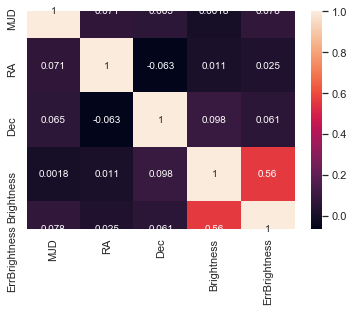

In [287]:
corr_matrix = df.corr().abs()
sns.heatmap(df.corr(), annot=True)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
print("Columns based on high corr > 0.80:")
print(to_drop)

In [294]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Neural Network Analysis of Brightness Error

In [295]:
data.columns

Index(['MJD', 'RA', 'Dec', 'Brightness'], dtype='object')

In [303]:
# do data splitting
data = df
x = data['ErrBrightness']
data = data.iloc[:,[0,1,2,3]]
print(data.columns)

Index(['MJD', 'RA', 'Dec', 'Brightness'], dtype='object')


In [304]:
xTrain, xTest, xTrainDS, xTestDS = train_test_split(data, x, test_size=0.3, random_state=2)

In [306]:
nnModX = MLPRegressor(hidden_layer_sizes=(5,3),
                     activation='tanh',
                     solver='lbfgs',
                     verbose=True)

In [307]:
nnModX.fit(xTrain, xTrainDS)
predX = nnModX.predict(xTest)
print(predX)

[0.18112394 0.18112394 0.18112394 ... 0.18112394 0.18112394 0.18112394]


In [309]:
dists = EucDist(predX, xTestDS)
meanED = np.mean(dists)
maxED = np.max(dists)
minED = np.min(dists)

print("meanED = " + str(meanED) + " mag")
print("maxED = " + str(maxED) + " mag")
print("minED = " + str(minED) + " mag")

meanED = 0.12821689151682542 mag
maxED = 18.96887606331474 mag
minED = 0.0011239366852559551 mag


               relu      tanh
(3,)       0.127570  0.127569
(5, 3)     0.127573  0.127642
(5, 3, 3)  0.127679  0.127576


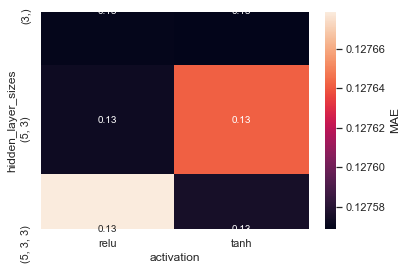

Best parameters for X regressor (NN):
{'activation': 'tanh', 'hidden_layer_sizes': (5, 3)}


In [310]:
# quick grid search
numCV = 5
paramsToTest = {'hidden_layer_sizes': [(3,),(5,3),(5,3,3)], 'activation': ['tanh', 'relu']}
NNResX = DoGridSearchTuning(xTrain, xTrainDS, numCV, paramsToTest, MLPRegressor(solver='lbfgs', verbose=True))
PlotResultsOfGridSearch(NNResX)
print("Best parameters for X regressor (NN):")
print(NNResX.best_params_)

In [311]:
NNResX.best_params_.update({'solver': 'lbfgs'})

nnModX = MLPRegressor(**NNResX.best_params_)
nnModX.fit(xTrain, xTrainDS)

EvaluateModelErr(xTest, xTrain, xTrainDS, xTestDS, nnModX, '--Metrics for Neural Network--')

--Metrics for Neural Network--
meanED = 0.1282093503295746 m
maxED = 18.968894397923368 m
minED = 0.0011056020766291863 m


## Neural Network Analysis for RA and DEC

In [313]:
# do data splitting
data2 = df
x = data2['RA']
y = data2['Dec']
data2 = data2.iloc[:,[0,3,4]]
print(data2.columns)

Index(['MJD', 'Brightness', 'ErrBrightness'], dtype='object')


In [314]:
xTrain, xTest, xTrainDS, xTestDS = train_test_split(data2, x, test_size=0.3, random_state=2)
yTrain, yTest, yTrainDS, yTestDS = train_test_split(data2, y, test_size=0.3, random_state=2)

nnModX = MLPRegressor(hidden_layer_sizes=(5,3),
                     activation='tanh',
                     solver='lbfgs',
                     verbose=True)

nnModX.fit(xTrain, xTrainDS)
predX = nnModX.predict(xTest)
print(predX)

nnModY = MLPRegressor(hidden_layer_sizes=(5,3),
                     activation='tanh',
                     solver='lbfgs',
                     verbose=True)

nnModY.fit(yTrain, yTrainDS)
predY = nnModY.predict(yTest)
print(predY)

[175.21575413 175.21575413 175.21575413 ... 175.21575413 175.21575413
 175.21575413]
[-5.58823987 -5.58823987 -5.58823987 ... -5.58823987 -5.58823987
 -5.58823987]


In [318]:
dists = EucDistXY(predX, predY, xTestDS, yTestDS)
meanED = np.mean(dists)
maxED = np.max(dists)
minED = np.min(dists)

print("meanED = " + str(meanED))
print("maxED = " + str(maxED))
print("minED = " + str(minED))

meanED = 89.45361796830935
maxED = 184.7809159668692
minED = 0.04524122797445592


                relu       tanh
(3,)       89.380124  89.380124
(5, 3)     89.380124  89.338282
(5, 3, 3)  89.359775  89.297082


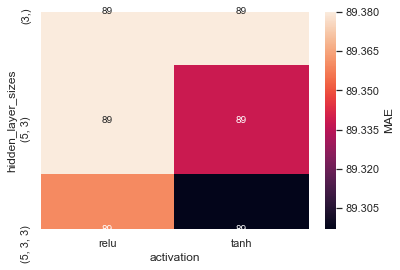

               relu      tanh
(3,)       0.052796  0.052797
(5, 3)     0.052797  0.058493
(5, 3, 3)  0.057039  0.054768


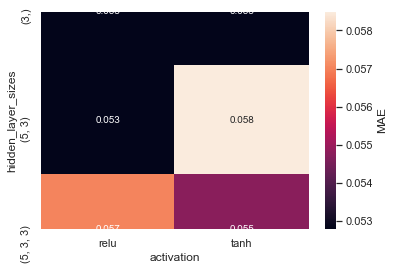

Best parameters for X regressor (NN):
{'activation': 'relu', 'hidden_layer_sizes': (5, 3, 3)}
Best parameters for Y regressor (NN):
{'activation': 'tanh', 'hidden_layer_sizes': (3,)}


In [319]:
# quick grid search
numCV = 5
paramsToTest = {'hidden_layer_sizes': [(3,),(5,3),(5,3,3)], 'activation': ['tanh', 'relu']}
NNResX = DoGridSearchTuning(xTrain, xTrainDS, numCV, paramsToTest, MLPRegressor(solver='lbfgs', verbose=True))
NNResY = DoGridSearchTuning(xTrain, yTrainDS, numCV, paramsToTest, MLPRegressor(solver='lbfgs', verbose=True))
PlotResultsOfGridSearch(NNResX)
PlotResultsOfGridSearch(NNResY)
print("Best parameters for X regressor (NN):")
print(NNResX.best_params_)
print("Best parameters for Y regressor (NN):")
print(NNResY.best_params_)

In [20]:
from skyfield.api import load

planets = load('de421.bsp')
earth, mars = planets['earth'], planets['mars']

ts = load.timescale()
t = ts.now()
position = earth.at(t).observe(mars)
ra, dec, distance = position.radec()

print(ra)
print(dec)
print(distance)

[#################################] 100% de421.bsp
[#################################] 100% deltat.data
[#################################] 100% deltat.preds
[#################################] 100% Leap_Second.dat


17h 00m 37.70s
-22deg 40' 23.2"
1.98065 au


## Retrieve Information from TLEs

In [129]:
from skyfield.api import load
from skyfield.sgp4lib import EarthSatellite
from skyfield.timelib import Time
import numpy as np
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv

TLE_SAT01 = """1 43205U 18017A   18038.05572532 +.00020608 -51169-6 +11058-3 0  9993
2 43205 029.0165 287.1006 3403068 180.4827 179.1544 08.75117793000017"""
L1Sat01, L2Sat01 = TLE_SAT01.splitlines()

data = load('de421.bsp')
ts   = load.timescale()
 
planets = load('de421.bsp')
earth   = planets['earth']
 
Sat01 = EarthSatellite(L1Sat01, L2Sat01, name ='Sat01')

print("Satellites Epoch Details::")
print(Sat01.epoch.tt)

satellite = twoline2rv(L1Sat01, L2Sat01, wgs72)
position, velocity = satellite.propagate(2020, 1, 29, 12, 30, 19)
print(satellite.error)
print(satellite.error_message)
print(position)
print(velocity)
print("Satellite Details::")
print(satellite.satnum)
print(satellite.epochyr)
print(satellite.epochdays)
print(satellite.jdsatepoch)
print(satellite.epoch)

Satellites Epoch Details::
2458156.5565260607
0
None
(-151.7318408531701, 7247.198554144504, 3377.3026543069805)
(-7.158530277566431, 2.5936944902246566, -0.8582839829975933)
Satellite Details::
43205
2018
38.05572532
2458156.55572532
2018-02-07 01:20:14.667648


## PLOT SATELLITE PATH USING TLEs

Satellites Epoch Details::
SAT01 MJD:: 2458156.5565260607
SAT01 Date:: A.D. 2018-Feb-07 01:20:14.6676 UT
SAT02 MJD:: 2458877.012157761
SAT02 Date:: A.D. 2020-Jan-28 12:16:21.2465 UT
Satellite 01 Position Shape Details::
(3, 240)
Satellite 02 Position Shape Details::
(3, 240)


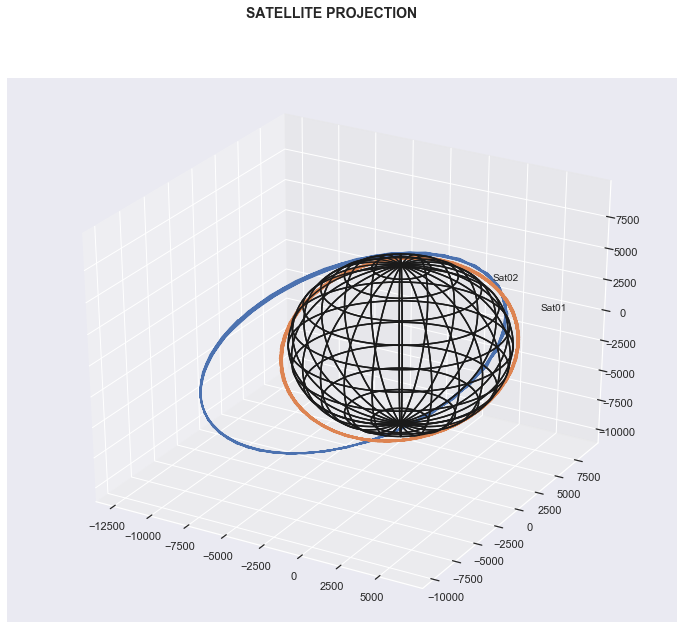

In [243]:
from skyfield.api import load, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims]
 
    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        #print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            #print("ok hw requested: ", hwx, hwy, hwz)
 
            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            #print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)
 
    return centers, hw
 
TLE_SAT01 = """1 43205U 18017A   18038.05572532 +.00020608 -51169-6 +11058-3 0  9993
2 43205 029.0165 287.1006 3403068 180.4827 179.1544 08.75117793000017"""
L1Sat01, L2Sat01 = TLE_SAT01.splitlines()

TLE_SAT02 = """1 44134U 19006V   20028.51135702  .00028421  94520-6  36871-3 0  9999
2 44134  96.0406 223.8096 0557427  94.7927 271.7136 14.67342941 44254"""
L1Sat02, L2Sat02 = TLE_SAT02.splitlines()

 
 
halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180
 
data = load('de421.bsp')
ts   = load.timescale()
 
planets = load('de421.bsp')
earth   = planets['earth']
 
Sat01 = EarthSatellite(L1Sat01, L2Sat01, name ='Sat01')
Sat02 = EarthSatellite(L1Sat02, L2Sat02, name ='Sat02')

print("Satellites Epoch Details::")
print("SAT01 MJD::", Sat01.epoch.tt)
print("SAT01 Date::",Sat01.epoch.utc_jpl())
print("SAT02 MJD::", Sat02.epoch.tt)
print("SAT02 Date::", Sat02.epoch.utc_jpl())

hours = np.arange(0, 24, 0.10)
time = ts.utc(2020, 1, 29, hours)

t = ts.utc(2020, 1, 29, 15, 30, 7)
 
Sat01pos    = Sat01.at(time).position.km
Sat01posecl = Sat01.at(time).ecliptic_position().km
print("Satellite 01 Position Shape Details::")
print(Sat01pos.shape)

Sat02pos    = Sat02.at(time).position.km
Sat02posecl = Sat02.at(time).ecliptic_position().km
print("Satellite 02 Position Shape Details::")
print(Sat02pos.shape)
 
re = 6378.
 
theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)
 
lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)
 
if True:    
    fig = plt.figure(figsize=[12, 10])
    fig.suptitle('SATELLITE PROJECTION', fontsize=14, fontweight='bold')
    ax  = fig.add_subplot(1, 1, 1, projection='3d')
 
    x, y, z = Sat01pos
    ax.plot(x, y, z)
    ax.text(8500, 500, 5000, Sat01.name)
    for x, y, z in lons:
        ax.plot(x, y, z, '-k')
    for x, y, z in lats:
        ax.plot(x, y, z, '-k')
        
    x, y, z = Sat02pos
    ax.plot(x, y, z)
    ax.text(5500, 500, 6500, Sat02.name)
    for x, y, z in lons:
        ax.plot(x, y, z, '-k')
    for x, y, z in lats:
        ax.plot(x, y, z, '-k')
 
    centers, hw = makecubelimits(ax)
 
    #print("centers are: ", centers)
    #print("hw is:       ", hw)
 
    plt.show()


r_Sat01 = np.sqrt((Rpos**2).sum(axis=0))
alt_Sat01 = r_Sat01 - re
r_Sat02 = np.sqrt((Rpos**2).sum(axis=0))
alt_Sat02 = r_Sat01 - re

if False:
    plt.figure()
    plt.plot(hours, r_Sat01)
    plt.plot(hours, alt_Sat01)
    plt.xlabel('hours', fontsize=14)
    plt.ylabel('Geocenter radius or altitude (km)', fontsize=14)
    plt.show()
    
if False:
    plt.figure()
    plt.plot(hours, r_Sat02)
    plt.plot(hours, alt_Sat02)
    plt.xlabel('hours', fontsize=14)
    plt.ylabel('Geocenter radius or altitude (km)', fontsize=14)
    plt.show()

In [324]:
from skyfield.api import position_from_radec, load_constellation_map
constellation_at = load_constellation_map()
north_pole = position_from_radec(0, 90)
constellation_at(north_pole)

'UMi'

## Finding and loading GEO satellite elements

You can find satellite element sets at the NORAD Two-Line Element Sets page of the Celestrak web site.

Beware that the two-line element (TLE) format is very rigid. The meaning of each character is based on its exact offset from the beginning of the line. You must download and use the element set’s text without making any change to its whitespace.

Skyfield loader objects offer a tle() method that can download and cache a file full of satellite elements from a site like Celestrak. A popular observing target for satellite observers is the International Space Station, which is listed in their stations.txt file:



  ``model.satnum``
        The unique satellite NORAD catalog number given in the TLE file.
    ``model.epochyr``
        Full four-digit year of this element set's epoch moment.
    ``model.epochdays``
        Fractional days into the year of the epoch moment.
    ``model.jdsatepoch``
        Julian date of the epoch (computed from ``epochyr`` and ``epochdays``).
    ``model.ndot``
        First time derivative of the mean motion (ignored by SGP4).
    ``model.nddot``
        Second time derivative of the mean motion (ignored by SGP4).
    ``model.bstar``
        Ballistic drag coefficient B* in inverse earth radii.
    ``model.inclo``
        Inclination in radians.
    ``model.nodeo``
        Right ascension of ascending node in radians.
    ``model.ecco``
        Eccentricity.
    ``model.argpo``
        Argument of perigee in radians.
    ``model.mo``
        Mean anomaly in radians.
    ``model.no``
        Mean motion in radians per minute.

In [207]:
from skyfield.api import Topos, load
#http://celestrak.com/NORAD/elements/stations.txt
stations_url = 'http://www.celestrak.com/NORAD/elements/geo.txt'
satellites = load.tle(stations_url)
#print(satellites)
print("::Satellite Details::")
satellite = satellites['GALAXY 15 (G-15)']
print(satellite)
print("Satellite Number:", satellite.model.satnum)
print("Satellite Epoch Year:", satellite.model.epochyr)
print("Satellite Epoch Days:", satellite.model.epochdays)
print("Satellite Perigee:", satellite.model.argpo)
print("Satellite Mean Anomaly:", satellite.model.mo)
print("Satellite Mean Eccentricity:", satellite.model.ecco)

::Satellite Details::
EarthSatellite 'GALAXY 15 (G-15)' number=28884 epoch=2020-01-29T11:50:43Z
Satellite Number: 28884
Satellite Epoch Year: 2020
Satellite Epoch Days: 29.49354878
Satellite Perigee: 0.720234550444988
Satellite Mean Anomaly: 3.8703566280892776
Satellite Mean Eccentricity: 0.0001771


In [191]:
print(satellite.epoch.utc_jpl())

A.D. 2020-Jan-29 11:50:42.6146 UT


The value shown for the “epoch” is the all-important date and time on which this set of elements is most accurate, and before or after which they go rapidly out of date. You can access this value as an attribute of the object in case your program wants to check how old the elements are:

If the epoch is too far in the past, you can provide tle() with the reload option to force it to download new elements even if the file is already on disk.

In [192]:
ts = load.timescale()
t = ts.utc(2020, 1, 29, 15, 30, 7)

days = t - satellite.epoch
print('{:.3f} days away from epoch'.format(days))

if abs(days) > 14:
    satellites = load.tle(stations_url, reload=True)
    satellite = satellites['GALAXY 15 (G-15)']

0.152 days away from epoch


Satellite 01 Position 01 Shape Details::
(3, 2400)
Satellite 01 Position 02 Shape Details::
(3, 2400)
Satellite 01 Position 03 Shape Details::
(3, 2400)


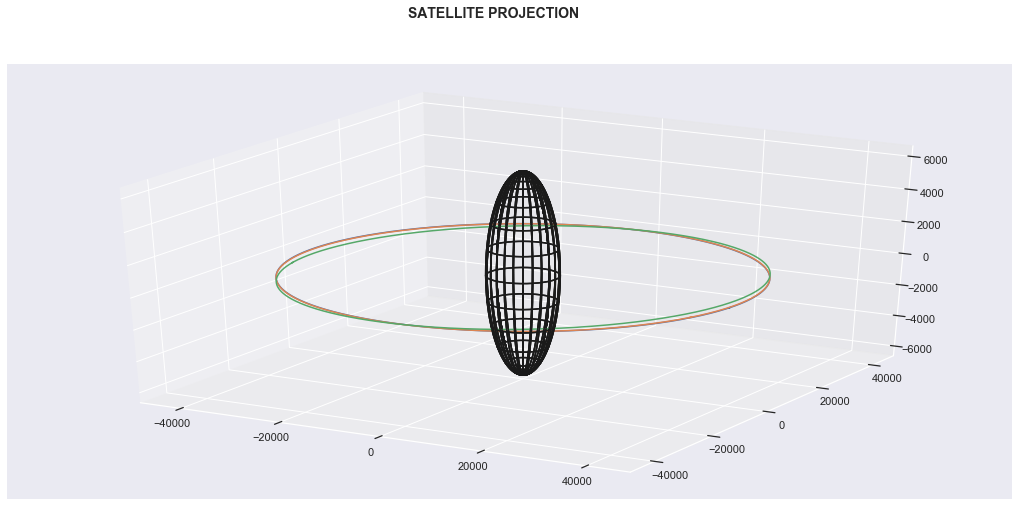

In [237]:
hours = np.arange(0, 24, 0.01)
time01 = ts.utc(2020, 1, 29, hours)
Sat01pos01= satellite.at(time01).position.km
print("Satellite 01 Position 01 Shape Details::")
print(Sat01pos01.shape)

time02 = ts.utc(2020, 1, 15, hours)
Sat01pos02= satellite.at(time02).position.km
print("Satellite 01 Position 02 Shape Details::")
print(Sat01pos02.shape)

time03 = ts.utc(2019, 7, 29, hours)
Sat01pos03= satellite.at(time03).position.km
print("Satellite 01 Position 03 Shape Details::")
print(Sat01pos03.shape)

    
if True:    
    fig = plt.figure(figsize=[18, 8])
    fig.suptitle('SATELLITE PROJECTION', fontsize=14, fontweight='bold')
    ax  = fig.add_subplot(1, 1, 1, projection='3d')
 
    x1, y1, z1 = Sat01pos01
    ax.plot(x1, y1, z1)
    for x1, y1, z1 in lons:
        ax.plot(x1, y1, z1, '-k')
    for x, y, z in lats:
        ax.plot(x1, y1, z1, '-k')
        
    x2, y2, z2 = Sat01pos02
    ax.plot(x2, y2, z2)
    for x2, y2, z2 in lons:
        ax.plot(x2, y2, z2, '-k')
    for x2, y2, z2 in lats:
        ax.plot(x2, y2, z2, '-k')
        
    x3, y3, z3 = Sat01pos03
    ax.plot(x3, y3, z3)
    for x3, y3, z3 in lons:
        ax.plot(x3, y3, z3, '-k')
    for x3, y3, z3 in lats:
        ax.plot(x3, y3, z3, '-k')
 
    #centers, hw = makecubelimits(ax)
    plt.show()

The simplest form in which you can generate a satellite position is to call its at() method, which will return an x, y, z position relative to the Earth’s center in the Geocentric Celestial Reference System. (GCRS coordinates are based on even more precise axes than those of the old J2000 system.)

In [171]:
geocentric = satellite.at(t)
print(geocentric.position.km)

[-28425.58155576 -31139.95250147     32.11434627]


Another approach is to ask which point on the Earth’s globe is directly beneath the satellite. You can access this through the subpoint() method of the geocentric position computed above.

In [113]:
subpoint = geocentric.subpoint()
print('Latitude:', subpoint.latitude)
print('Longitude:', subpoint.longitude)
print('Elevation (m):', int(subpoint.elevation.m))

Latitude: 09deg 05' 51.2"
Longitude: 176deg 46' 20.5"
Elevation (m): 416270


Finally, you might be most interested in whether the satellite is above or below the horizon from your own position as an observer. If you build a Topos object to represent your location, you can use vector subtraction to ask “where will the satellite be relative to my location?”

In [114]:
bluffton = Topos('40.8939 N', '83.8917 W')
difference = satellite - bluffton
print(difference)

Sum of 2 vectors:
 - Topos 40deg 53' 38.0" N -83deg 53' 30.1" E
 + EarthSatellite 'ISS (ZARYA)' number=25544 epoch=2020-01-29T12:29:20Z


Every time you call this vector sum’s at() method, it will first compute the satellite’s position, then your own position, and finish by subtracting them. The result will be the position of the satellite relative to you as an observer. If you are interested you can access this relative position as x, y, z coordinates, just as you did for the position measured from the Earth’s center:

In [115]:
topocentric = difference.at(t)
print(topocentric.position.km)

[-1482.58179234  8755.5703127  -3082.96368796]


But the most popular approach is to ask the topocentric position for its altitude and azimuth coordinates, which tell you whether the satellite is above or below the horizon:

In [117]:
alt, az, distance = topocentric.altaz()

if alt.degrees > 0:
    print('The ISS is above the horizon')
else:
    print('The ISS is below the horizon')

print(alt)
print(az)
print(distance.km)

The ISS is below the horizon
-43deg 41' 11.8"
283deg 06' 03.0"
9400.144965519894


If you are interested in where among the stars the satellite will be positioned, then — as with any other Skyfield position object — you can also ask for a right ascension and declination, either relative to the fixed axes of the ICRF or else in dynamical coordinates of the date you specify.

In [118]:
ra, dec, distance = topocentric.radec()  # ICRF ("J2000")

print(ra)
print(dec)

06h 38m 26.58s
-19deg 08' 44.1"


In [151]:
ra, dec, distance = topocentric.radec(epoch='date')

print(ra)
print(dec)

06h 39m 18.31s
-19deg 09' 52.0"


When computing positions for the Sun, Moon, planets, and stars, Skyfield encourages a far more fussy approach than directly subtracting two vectors. In those cases, the user is encouraged to compute their current location with at() and then call the observe() method on the result so that Skyfield can correctly adjust the object’s position for the time it takes light to travel.

This turns out to be expensive for Earth satellites, however, because the routines with which Skyfield computes satellite positions are not currently very fast.
And it turns out to be useless, because satellites are too close and move far too slowly (at least compared to something like a planet) for the light travel time to make any difference.
How far off will your observations be if you simply subtract your position vector from the satellite’s vector, as encouraged above? Let’s try the alternative and measure the difference.

To use the observe() method, you need a position measured all the way from the Solar System Barycenter (SSB). To anchor both our observer location and that of the satellite to the SSB, we can use vector addition with an ephemeris that predicts the Solar System position of the Earth:

In [120]:
# OVERLY EXPENSIVE APPROACH - Compute both the satellite
# and observer positions relative to the Solar System
# barycenter ("ssb"), then call observe() to compensate
# for light-travel time.

de421 = load('de421.bsp')
earth = de421['earth']
ssb_bluffton = earth + bluffton
ssb_satellite = earth + satellite
topocentric2 = ssb_bluffton.at(t).observe(ssb_satellite).apparent()

In [121]:
# After all that work, how big is the difference, really?

difference_km = (topocentric2 - topocentric).distance().km
print('Difference between the two positions:')
print('{0:.3f} km'.format(difference_km))

difference_angle = topocentric2.separation_from(topocentric)
print('Angle between the two positions in the sky:')
print('{}'.format(difference_angle))

Difference between the two positions:
0.387 km
Angle between the two positions in the sky:
00deg 00' 05.3"


Detecting Propagation Errors

After building a satellite object, you can examine the epoch date and time when the TLE element set’s predictions are most accurate. The epoch attribute is a Time, so it supports all of the standard Skyfield date methods:

In [122]:
from skyfield.api import EarthSatellite

text = """
GOCE
1 34602U 09013A   13314.96046236  .14220718  20669-5  50412-4 0   930
2 34602 096.5717 344.5256 0009826 296.2811 064.0942 16.58673376272979
"""
lines = text.strip().splitlines()

sat = EarthSatellite(lines[1], lines[2], lines[0])
print(sat.epoch.utc_jpl())

A.D. 2013-Nov-10 23:03:03.9479 UT


In [123]:
geocentric = sat.at(ts.utc(2013, 11, 9))
print('Before:')
print(geocentric.position.km)
print(geocentric.message)

geocentric = sat.at(ts.utc(2013, 11, 13))
print('\nAfter:')
print(geocentric.position.km)
print(geocentric.message)

Before:
[nan nan nan]
mean eccentricity -0.001416 not within range 0.0 <= e < 1.0

After:
[nan nan nan]
mrt 0.997178 is less than 1.0 indicating the satellite has decayed


In [132]:
from skyfield.api import load

planets = load('de421.bsp')
earth, mars = planets['earth'], planets['mars']

ts = load.timescale()
t = ts.now()
position = earth.at(t).observe(mars)
ra, dec, distance = position.radec()

print(ra)
print(dec)
print(distance)

17h 06m 18.27s
-22deg 49' 30.8"
1.96534 au


Satellites Epoch Details::
SAT01 MJD:: 2458878.6247244608
SAT01 Date:: A.D. 2020-Jan-30 02:58:27.0094 UT
SAT02 MJD:: 2458693.927684111
SAT02 Date:: A.D. 2019-Jul-29 10:14:42.7232 UT
SAT03 MJD:: 2458513.446006461
SAT03 Date:: A.D. 2019-Jan-29 22:41:05.7742 UT
Satellite 01 Position Shape Details::
(3, 80)
Satellite 02 Position Shape Details::
(3, 80)
Satellite 03 Position Shape Details::
(3, 80)
hw was None so set to: 46380.64771570716
centers are:  [-4.247959478401754, 6.076372600262403, 0.0]
hw is:        46380.64771570716


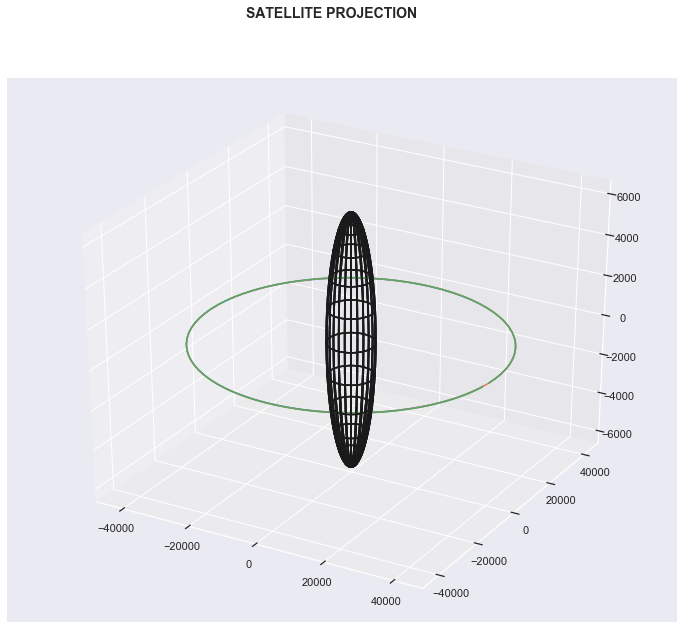

In [270]:
from skyfield.api import load, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def plotaxislimit(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims]
 
    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)
            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)
 
    return centers, hw
 
TLE_SAT01 = """1 28884U 05041A   20030.12392372  .00000082  00000-0  00000+0 0  9993
2 28884   0.0587 269.2229 0001764  37.9111  93.2791  1.00270805 52263"""
L1Sat01, L2Sat01 = TLE_SAT01.splitlines()

TLE_SAT02 = """1 28884U 05041A   19210.42688337  .00000078  00000-0  00000+0 0  9998
2 28884   0.0595 269.5353 0001937 216.2932 201.6080  1.00272640 50407"""
L1Sat02, L2Sat02 = TLE_SAT02.splitlines()

TLE_SAT03 = """1 28884U 05041A   19029.94520572  .00000068  00000-0  00000+0 0  9998
2 28884   0.0411 270.7112 0001828  43.2457  22.1983  1.00273963 48594"""
L1Sat03, L2Sat03 = TLE_SAT03.splitlines()

 
halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180
 
data = load('de421.bsp')
ts   = load.timescale()
 
planets = load('de421.bsp')
earth   = planets['earth']
 
Sat01 = EarthSatellite(L1Sat01, L2Sat01, name ='Sat01')
Sat02 = EarthSatellite(L1Sat02, L2Sat02, name ='Sat02')
Sat03 = EarthSatellite(L1Sat03, L2Sat03, name ='Sat03')

print("Satellites Epoch Details::")
print("SAT01 MJD::", Sat01.epoch.tt)
print("SAT01 Date::",Sat01.epoch.utc_jpl())
print("SAT02 MJD::", Sat02.epoch.tt)
print("SAT02 Date::", Sat02.epoch.utc_jpl())
print("SAT03 MJD::", Sat03.epoch.tt)
print("SAT03 Date::", Sat03.epoch.utc_jpl())

hours = np.arange(0, 24, 0.30)
time1 = ts.utc(2020, 1, 30, hours)
time2 = ts.utc(2019, 7, 29, hours)
time3 = ts.utc(2019, 1, 29, hours)
 
Sat01pos    = Sat01.at(time1).position.km
Sat01posecl = Sat01.at(time1).ecliptic_position().km
print("Satellite 01 Position Shape Details::")
print(Sat01pos.shape)

Sat02pos    = Sat02.at(time2).position.km
Sat02posecl = Sat02.at(time2).ecliptic_position().km
print("Satellite 02 Position Shape Details::")
print(Sat02pos.shape)

Sat03pos    = Sat03.at(time3).position.km
Sat03posecl = Sat03.at(time3).ecliptic_position().km
print("Satellite 03 Position Shape Details::")
print(Sat03pos.shape)
 
re = 6378.
 
theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)
 
lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)
 
if True:    
    figPlot = plt.figure(figsize=[12, 10])
    figPlot.suptitle('SATELLITE PROJECTION', fontsize=14, fontweight='bold')
    axdet  = figPlot.add_subplot(1, 1, 1, projection='3d')
 
    x, y, z = Sat01pos
    axdet.plot(x, y, z)
    #ax.text(8500, 500, 5000, Sat01.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')
        
    x, y, z = Sat02pos
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 6500, Sat02.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')
        
    x, y, z = Sat03pos
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 8500, Sat03.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')
 
    centers, hw = plotaxislimit(axdet)
 
    print("centers are: ", centers)
    print("hw is:       ", hw)
 
    plt.show()

Satellites Epoch Details::
SAT01 MJD:: 2458878.6247244608
SAT01 Date:: A.D. 2020-Jan-30 02:58:27.0094 UT
SAT02 MJD:: 2458878.345971361
SAT02 Date:: A.D. 2020-Jan-29 20:17:02.7415 UT
SAT03 MJD:: 2458878.344662821
SAT03 Date:: A.D. 2020-Jan-29 20:15:09.6837 UT
Satellite 01 Position Shape Details::
(3, 240)
Satellite 02 Position Shape Details::
(3, 240)
Satellite 02 Position Shape Details::
(3, 240)
hw was None so set to: 46380.64771570716
centers are:  [-4.247959478401754, 6.076372600262403, 0.0]
hw is:        46380.64771570716


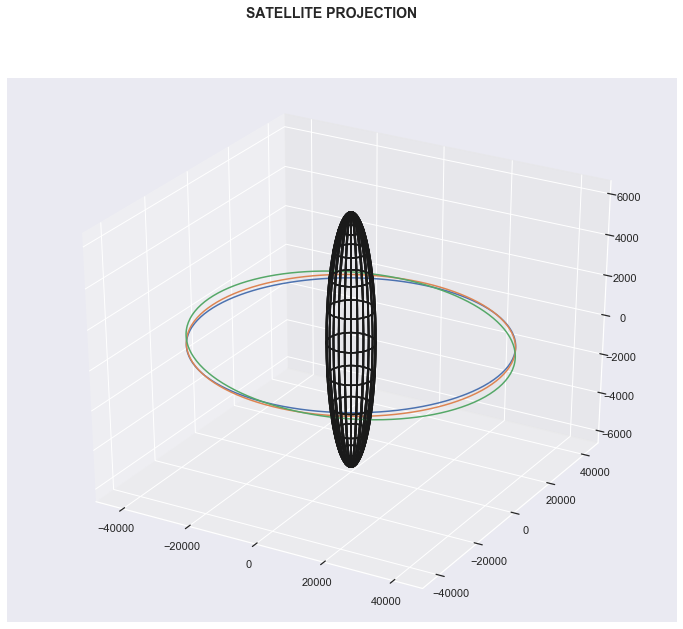

In [273]:
from skyfield.api import load, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def plotaxislimit(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims]
 
    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)
            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)
 
    return centers, hw
 
TLE_SAT01 = """1 28884U 05041A   20030.12392372  .00000082  00000-0  00000+0 0  9993
2 28884   0.0587 269.2229 0001764  37.9111  93.2791  1.00270805 52263"""
L1Sat01, L2Sat01 = TLE_SAT01.splitlines()

TLE_SAT02 = """1 31307U 07016B   20029.84517062 -.00000172 +00000-0 +00000-0 0  9995
2 31307 000.0144 049.2561 0002895 279.7436 012.7884 01.00273452046581"""
L1Sat02, L2Sat02 = TLE_SAT02.splitlines()

TLE_SAT03 = """1 33376U 08045A   20029.84386208 -.00000137 +00000-0 +00000-0 0  9993
2 33376 000.0144 083.3835 0003423 241.4462 010.5182 01.00269837041578"""
L1Sat03, L2Sat03 = TLE_SAT03.splitlines()

 
halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180
 
data = load('de421.bsp')
ts   = load.timescale()
 
planets = load('de421.bsp')
earth   = planets['earth']
 
Sat01 = EarthSatellite(L1Sat01, L2Sat01, name ='Sat01')
Sat02 = EarthSatellite(L1Sat02, L2Sat02, name ='Sat02')
Sat03 = EarthSatellite(L1Sat03, L2Sat03, name ='Sat03')

print("Satellites Epoch Details::")
print("SAT01 MJD::", Sat01.epoch.tt)
print("SAT01 Date::",Sat01.epoch.utc_jpl())
print("SAT02 MJD::", Sat02.epoch.tt)
print("SAT02 Date::", Sat02.epoch.utc_jpl())
print("SAT03 MJD::", Sat03.epoch.tt)
print("SAT03 Date::", Sat03.epoch.utc_jpl())

hours = np.arange(0, 24, 0.10)
time1 = ts.utc(2020, 1, 30, hours)
time2 = ts.utc(2019, 7, 29, hours)
time3 = ts.utc(2019, 1, 29, hours)
 
Sat01pos    = Sat01.at(time1).position.km
Sat01posecl = Sat01.at(time1).ecliptic_position().km
print("Satellite 01 Position Shape Details::")
print(Sat01pos.shape)

Sat02pos    = Sat02.at(time2).position.km
Sat02posecl = Sat02.at(time2).ecliptic_position().km
print("Satellite 02 Position Shape Details::")
print(Sat02pos.shape)

Sat03pos    = Sat03.at(time3).position.km
Sat03posecl = Sat03.at(time3).ecliptic_position().km
print("Satellite 02 Position Shape Details::")
print(Sat03pos.shape)
 
re = 6378.
 
theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)
 
lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)
 
if True:    
    figPlot = plt.figure(figsize=[12, 10])
    figPlot.suptitle('SATELLITE PROJECTION', fontsize=14, fontweight='bold')
    axdet  = figPlot.add_subplot(1, 1, 1, projection='3d')
 
    x, y, z = Sat01pos
    axdet.plot(x, y, z)
    #ax.text(8500, 500, 5000, Sat01.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')
        
    x, y, z = Sat02pos
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 6500, Sat02.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')
        
    x, y, z = Sat03pos
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 8500, Sat03.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')
 
    centers, hw = plotaxislimit(axdet)
 
    print("centers are: ", centers)
    print("hw is:       ", hw)
 
    plt.show()